# Parameter inference for a distribution within the Bayesian Framework


In [1]:
# Didactical script for Bayesian inference of parameters
# O. Wani (May, 2020)
# Metropolis-Hastings algorithm:
# adapted from fJoseph Moukarzel (Towards data science: https://tinyurl.com/yxaqdjv2)

import matplotlib.pyplot as plt # package for good plots
import pandas as pd             # package for data analytics
import numpy as np              # package for efficient numerics
import plotly.offline as py     # for dynamic plots
import cufflinks as cf          # plotly bindings for pandas
import seaborn as sns           # for nice plots
import scipy.stats as stats     # fit a GEV distribution

# other modules that can be employed for inference
#import emcee
#import mc3
#import sys
#from pydream.parameters import FlatParam
#from pydream.core import run_dream
#from pydream.convergence import  Gelman_Rubin

In [33]:
# import data (change the adress to the folder AMS - provided by Lauren)
data1 = ("/home/owani/Python/AMS/AMS_r85_GFDLWRF1h_22_inch.txt")
data2 = ("/home/owani/Python/AMS/AMS_r85_MPIREG1h_22_inch.txt")
data3 = ("/home/owani/Python/AMS/AMS_r85_MPIWRF1h_22_inch.txt")
dat1  = pd.read_csv(filepath_or_buffer=data1,delimiter  =',',header =0)
dat2  = pd.read_csv(filepath_or_buffer=data2,delimiter  =',',header =0)
dat3  = pd.read_csv(filepath_or_buffer=data3,delimiter  =',',header =0)
datin =  pd.DataFrame({'dat1':dat1['AMS_cdx'],'dat2':dat2['AMS_cdx'], 'dat3':dat3['AMS_cdx']})

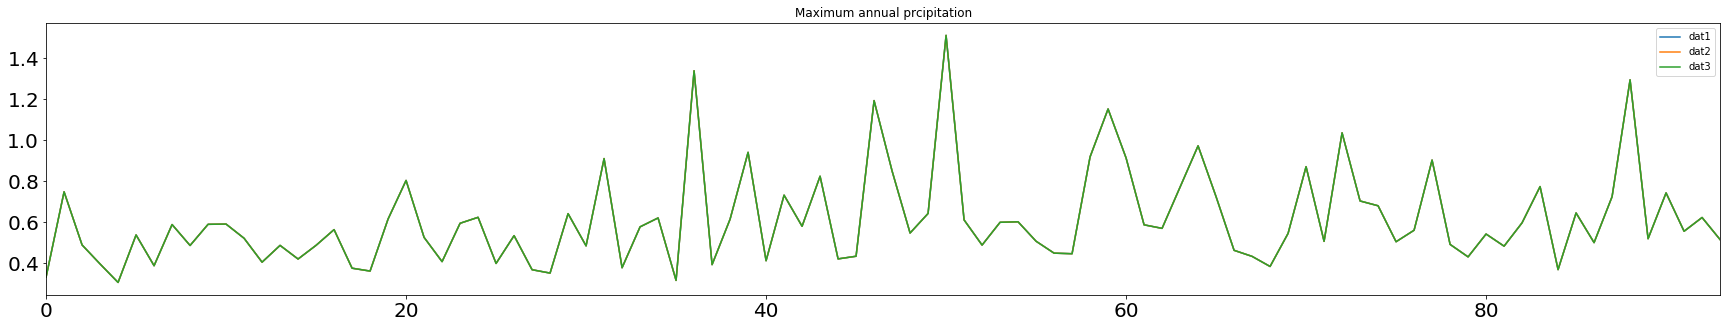

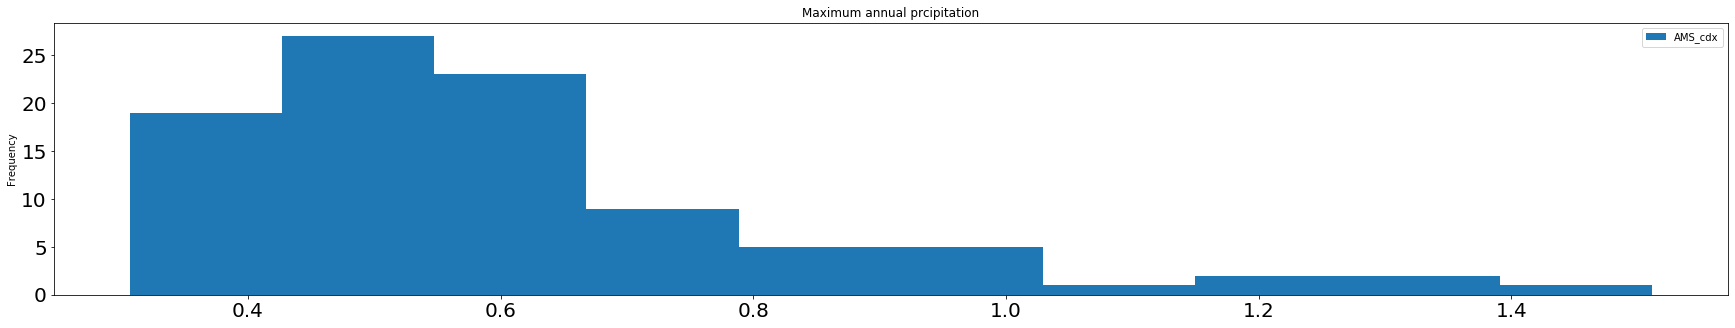

In [34]:
datin.plot(kind='line', figsize=[30,5], fontsize = 20, title = 'Maximum annual prcipitation')
dat3.plot(kind='hist',y ='AMS_cdx', figsize=[30,5], fontsize = 20, title = 'Maximum annual prcipitation')

In [36]:
# use scipy.stats to get the 'best guess' values of parameters
shape1, loc1, scale1 =stats.genextreme.fit(datin.dat1)
print(shape1, loc1, scale1)

-0.19284385409629531 0.49781421659352465 0.14129465001645458


In [37]:
# use scipy.stats to get the 'best guess' values of parameters
shape2, loc2, scale2 =stats.genextreme.fit(datin.dat1)
print(shape2, loc2, scale2)

-0.19284385409629531 0.49781421659352465 0.14129465001645458


In [41]:
# write the code for inference using the Bayesian 'machinery'

#define prior
def log_prior(par):
    par = pd.DataFrame(par,columns=['a'])
    if(all(par.a[1:3] >= 0)):
        return 0
    else:
        return float('-inf')

#define likelihood function

def log_lik_gev(par,data):
    #x[0]=mu, x[1]=sigma (new or current)
    #data = the observation
    return np.sum(np.log(stats.genextreme(par[0],par[1],par[2]).pdf([data])))

#define posterior
def log_post(par, data):
    if (log_prior(par)==float('-inf')):
        lp = log_prior(par)
    else: 
        lp = log_lik_gev(par,data)
    return lp    


In [42]:
# check whether the functions work
a = log_lik_gev((-0.1,0.1,0.1),datin.dat1)
b = log_post((0,0.1,0.1), datin.dat2)
a, b

(-202.53389995278945, -265.5284307012871)

In [44]:
#Define jumpt distribution or the transition model

transition_model = lambda x: x+np.random.normal(0,0.1,len(x))

#Defines whether to accept or reject the new sample
def acceptance(x, x_new):
    if x_new>x:
        return True
    else:
        accept=np.random.uniform(0,1)
        # Since we did a log likelihood, we need to exponentiate in order to compare to the random number
        # less likely x_new are less likely to be accepted
        return (accept < (np.exp(x_new-x)))

# Define the MCMC algorithm
    
def metropolis_hastings(likelihood_computer, transition_model, param_init,iterations,data,acceptance_rule):
    # likelihood_computer(x,data): returns the likelihood that these parameters generated the data
    # transition_model(x): a function that draws a sample from a symmetric distribution and returns it
    # param_init: a starting sample
    # iterations: number of accepted to generated
    # data: the data that we wish to model
    # acceptance_rule(x,x_new): decides whether to accept or reject the new sample
    x = param_init
    
    accepted = []
    rejected = []   
    for i in range(iterations):
        x_new =  transition_model(x)    
        x_lik = likelihood_computer(x,data)
        x_new_lik = likelihood_computer(x_new,data) 
        
        if (acceptance_rule(x_lik,x_new_lik)):            
            x = x_new
            accepted.append(x_new)
        else:
            rejected.append(x_new)
            accepted.append(x)
                
    return np.array(accepted), np.array(rejected)

In [49]:
accepted, rejected = metropolis_hastings(likelihood_computer = log_post, transition_model = transition_model,param_init = (-0.2,0.1,0.1), iterations = 15000, data =datin.dat1, acceptance_rule = acceptance)


/home/owani/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning:

divide by zero encountered in log



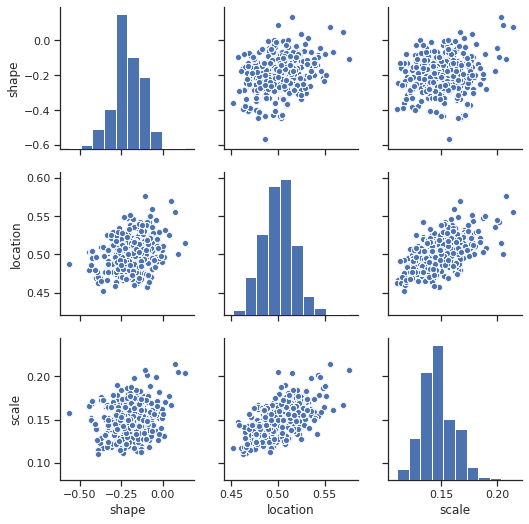

In [50]:
sns.set(style="ticks")
sns.pairplot(pd.DataFrame(accepted[1000:15000,:], columns = ['shape','location','scale']))

In [54]:
shape, loc, scale = accepted[:,0].mean(), accepted[:,1].mean(), accepted[:,2].mean()
shape, loc, scale # infered parameter 

(-0.21799651777529774, 0.49979924309255574, 0.14646441248749414)

In [55]:
spread = accepted[:,0].std(), accepted[:,1].std(), accepted[:,2].std()
spread

(0.09045514439319977, 0.018471902990941962, 0.014560027378598054)